In [ ]:
!gdown https://drive.google.com/uc?id=1coM7x3378f-Ou2l6Pg2wldaOI7Dntu1a
!unzip Covid_Data_GradientCrescent.zip
!rm Covid_Data_GradientCrescent.zip
!rm -rf /content/all/test/pneumonia_vir
!rm -rf /content/all/train/pneumonia_vir

Downloading...
From: https://drive.google.com/uc?id=1coM7x3378f-Ou2l6Pg2wldaOI7Dntu1a
To: /content/Covid_Data_GradientCrescent.zip
154MB [00:01, 132MB/s]
Archive:  Covid_Data_GradientCrescent.zip
   creating: all/
   creating: all/test/
   creating: all/test/covid/
  inflating: all/test/covid/nejmoa2001191_f3-PA.jpeg  
  inflating: all/test/covid/nejmoa2001191_f4.jpeg  
  inflating: all/test/covid/nejmoa2001191_f5-PA.jpeg  
  inflating: all/test/covid/radiol.2020200490.fig3.jpeg  
  inflating: all/test/covid/ryct.2020200028.fig1a.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig2.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig5-day0.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig5-day4.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig5-day7.jpeg  
   creating: all/test/normal/
  inflating: all/test/normal/NORMAL2-IM-1385-0001.jpeg  
  inflating: all/test/normal/NORMAL2-IM-1396-0001.jpeg  
  inflating: all/test/normal/NORMAL2-IM-1400-0001.jpeg  
  inflating: all/

In [ ]:
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import shutil

Using TensorFlow backend.


In [ ]:
DATASET_PATH = '/content/all/train'
test_dir = '/content/all/test'
IMAGE_SIZE = (150, 150)
NUM_CLASSES = 3
BATCH_SIZE = 10 # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS = 20
#LEARNING_RATE =0.0001
LEARNING_RATE = 0.00005 
FOLDS = 10

In [ ]:
class DirectoryStratifiedKFold:
  
  def __init__(self, directory, k, fold_dir = '/content'):
    self.directory = directory
    self.k = k
    self.fold_dir = fold_dir
    self.labels = os.listdir(directory) 
    self.files = []

    for label in self.labels:
      self.files.append(os.listdir(directory + '/' + label))

  def gen_fold(self, n, base = '__tempfold__'):
    fold = self.fold_dir + '/' + base + str(n)
    sub_train = '/train'
    sub_test = '/test'
    if not os.path.isdir(fold):
      os.mkdir(fold)
      os.mkdir(fold + sub_train)
      os.mkdir(fold + sub_test)
      for label, files in zip(self.labels, self.files):
        os.mkdir(fold + sub_train + '/' + label)
        os.mkdir(fold + sub_test + '/' + label)
        lower = (n) * (len(files) / self.k)
        upper = (n + 1) * (len(files) / self.k)
        for i, file in enumerate(files):
          if (lower <= i and i < upper):
            shutil.copy(self.directory + '/' + label + '/' + file, fold + sub_test + '/' + label + '/' + file)
          else:
            shutil.copy(self.directory + '/' + label + '/' + file, fold + sub_train + '/' + label + '/' + file)

    return (fold + sub_train, fold + sub_test)

  def del_fold(self, n, base = '__tempfold__'):
    fold = self.fold_dir + '/' + base + str(n)
    if os.path.isdir(fold):
      shutil.rmtree(fold)

  def shuffle(self):
    for label in self.files:
      np.random.shuffle(label)


In [ ]:
#Train datagen here is a preprocessor
train_datagen = ImageDataGenerator(rescale=1./255,
                                   featurewise_center = True,
                                   featurewise_std_normalization = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.25,
                                   zoom_range=0.1,
                                   zca_whitening = True,
                                   channel_shift_range = 20,
                                   horizontal_flip = True,
                                   fill_mode='constant')
#train_batches = train_datagen.flow_from_directory(DATASET_PATH,
#                                                  target_size=IMAGE_SIZE,
#                                                  shuffle=True,
#                                                  batch_size=BATCH_SIZE,
#                                                  subset = 'training',
#                                                  seed=42,
#                                                  class_mode='categorical')
#valid_batches = train_datagen.flow_from_directory(DATASET_PATH,
#                                                  target_size=IMAGE_SIZE,
#                                                  shuffle=True,
#                                                  batch_size=BATCH_SIZE,
#                                                  subset = 'validation',
#                                                  seed=42,
#                                                  class_mode='categorical')

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:341: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


In [ ]:
from keras import models
from keras import layers
from keras.applications import VGG16
from keras import optimizers
from keras.layers.core import Flatten, Dense, Dropout, Lambda
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['acc'])
weights = model.get_weights()

test_batches = train_datagen.flow_from_directory(test_dir,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical')

58892288/58889256 [==============================] - 5s 0us/step
Found 27 images belonging to 3 classes.


In [ ]:
def plot_acc_loss(result, epochs):
    acc = result.history['acc']
    loss = result.history['loss']
    val_acc = result.history['val_acc']
    val_loss = result.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train_acc')
    plt.plot(range(1,epochs), val_acc[1:], label='Test_acc')
    plt.title('Accuracy over '+ str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train_loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Test_loss')
    plt.title('Loss over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
kfold = DirectoryStratifiedKFold(DATASET_PATH, FOLDS)
kfold.shuffle()
results = []
evaluations = []


 Fold 0 

Found 180 images belonging to 3 classes.
Found 20 images belonging to 3 classes.
Epoch 1/20


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


18/18 [==============================] - 9s 474ms/step - loss: 1.0410 - acc: 0.4611 - val_loss: 0.8661 - val_acc: 0.6500
Epoch 2/20
18/18 [==============================] - 4s 230ms/step - loss: 0.7714 - acc: 0.6889 - val_loss: 0.7121 - val_acc: 0.9000
Epoch 3/20
18/18 [==============================] - 4s 233ms/step - loss: 0.6651 - acc: 0.7944 - val_loss: 0.5757 - val_acc: 0.7500
Epoch 4/20
18/18 [==============================] - 4s 231ms/step - loss: 0.5535 - acc: 0.8333 - val_loss: 0.4581 - val_acc: 0.9000
Epoch 5/20
18/18 [==============================] - 4s 233ms/step - loss: 0.5011 - acc: 0.8444 - val_loss: 0.2520 - val_acc: 0.9000
Epoch 6/20
18/18 [==============================] - 4s 238ms/step - loss: 0.4611 - acc: 0.8389 - val_loss: 0.2009 - val_acc: 0.9500
Epoch 7/20
18/18 [==============================] - 4s 235ms/step - loss: 0.4099 - acc: 0.8889 - val_loss: 0.2963 - val_acc: 0.9500
Epoch 8/20
18/18 [==============================] - 4s 231ms/step - loss: 0.3593 - acc:

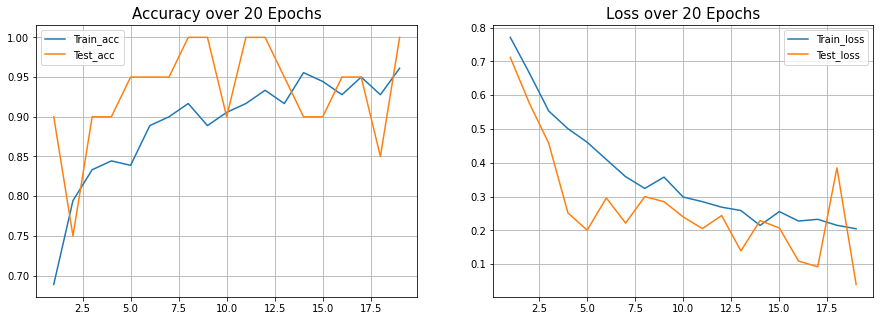

[0.5020828247070312, 0.7777777910232544]

 Fold 1 

Found 180 images belonging to 3 classes.
Found 20 images belonging to 3 classes.
Epoch 1/20
18/18 [==============================] - 4s 233ms/step - loss: 1.0518 - acc: 0.4278 - val_loss: 0.7825 - val_acc: 0.7000
Epoch 2/20
18/18 [==============================] - 4s 232ms/step - loss: 0.7718 - acc: 0.6333 - val_loss: 0.5692 - val_acc: 0.7000
Epoch 3/20
18/18 [==============================] - 4s 233ms/step - loss: 0.6564 - acc: 0.6889 - val_loss: 0.4734 - val_acc: 0.9500
Epoch 4/20
18/18 [==============================] - 4s 231ms/step - loss: 0.5189 - acc: 0.8389 - val_loss: 0.6862 - val_acc: 0.8500
Epoch 5/20
18/18 [==============================] - 4s 233ms/step - loss: 0.4722 - acc: 0.8222 - val_loss: 0.4087 - val_acc: 0.8500
Epoch 6/20
18/18 [==============================] - 4s 228ms/step - loss: 0.3971 - acc: 0.8889 - val_loss: 0.3502 - val_acc: 0.9500
Epoch 7/20
18/18 [==============================] - 4s 231ms/step - loss: 0

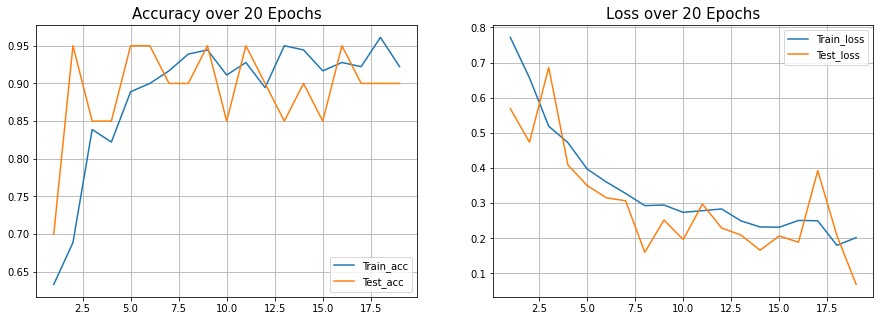

[0.24850571155548096, 0.8518518805503845]

 Fold 2 

Found 180 images belonging to 3 classes.
Found 20 images belonging to 3 classes.
Epoch 1/20
18/18 [==============================] - 4s 230ms/step - loss: 1.0548 - acc: 0.4444 - val_loss: 0.8071 - val_acc: 0.9000
Epoch 2/20
18/18 [==============================] - 4s 229ms/step - loss: 0.7674 - acc: 0.7000 - val_loss: 0.7357 - val_acc: 0.6500
Epoch 3/20
18/18 [==============================] - 4s 236ms/step - loss: 0.6139 - acc: 0.7722 - val_loss: 0.6021 - val_acc: 0.9000
Epoch 4/20
18/18 [==============================] - 4s 229ms/step - loss: 0.4933 - acc: 0.8556 - val_loss: 0.3727 - val_acc: 0.9000
Epoch 5/20
18/18 [==============================] - 4s 229ms/step - loss: 0.4023 - acc: 0.8889 - val_loss: 0.4710 - val_acc: 0.9500
Epoch 6/20
18/18 [==============================] - 4s 231ms/step - loss: 0.3935 - acc: 0.9000 - val_loss: 0.2318 - val_acc: 1.0000
Epoch 7/20
18/18 [==============================] - 4s 229ms/step - loss: 

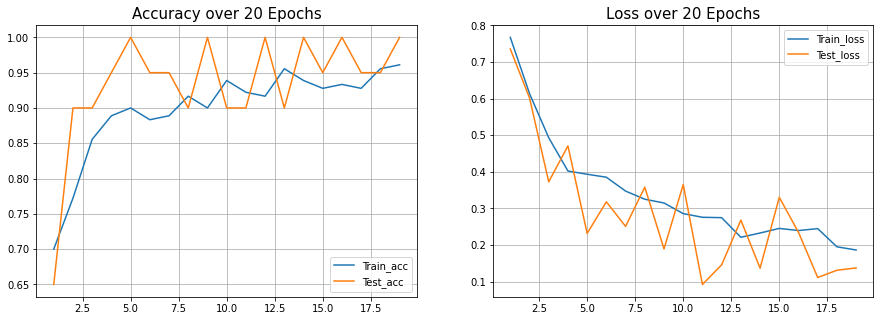

[0.2945501208305359, 0.7407407164573669]

 Fold 3 

Found 180 images belonging to 3 classes.
Found 20 images belonging to 3 classes.
Epoch 1/20
18/18 [==============================] - 4s 231ms/step - loss: 1.0279 - acc: 0.4611 - val_loss: 0.8502 - val_acc: 0.8000
Epoch 2/20
18/18 [==============================] - 4s 231ms/step - loss: 0.7482 - acc: 0.7444 - val_loss: 0.7285 - val_acc: 0.8000
Epoch 3/20
18/18 [==============================] - 4s 230ms/step - loss: 0.6124 - acc: 0.7500 - val_loss: 0.5084 - val_acc: 0.8500
Epoch 4/20
18/18 [==============================] - 4s 231ms/step - loss: 0.5254 - acc: 0.8278 - val_loss: 0.3836 - val_acc: 0.9500
Epoch 5/20
18/18 [==============================] - 4s 231ms/step - loss: 0.4278 - acc: 0.8889 - val_loss: 0.3968 - val_acc: 0.9500
Epoch 6/20
18/18 [==============================] - 4s 231ms/step - loss: 0.3794 - acc: 0.9278 - val_loss: 0.2973 - val_acc: 0.9000
Epoch 7/20
18/18 [==============================] - 4s 231ms/step - loss: 0

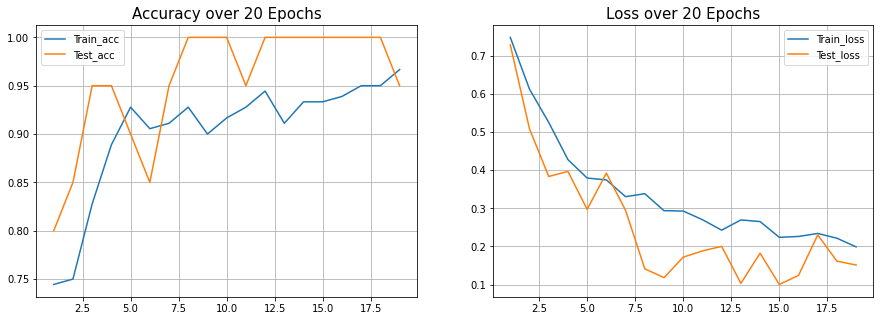

[0.2297775000333786, 0.8148148059844971]

 Fold 4 

Found 180 images belonging to 3 classes.
Found 20 images belonging to 3 classes.
Epoch 1/20
18/18 [==============================] - 4s 233ms/step - loss: 1.0336 - acc: 0.4722 - val_loss: 0.8796 - val_acc: 0.5500
Epoch 2/20
18/18 [==============================] - 4s 232ms/step - loss: 0.7298 - acc: 0.7222 - val_loss: 0.4864 - val_acc: 0.7500
Epoch 3/20
18/18 [==============================] - 4s 227ms/step - loss: 0.5764 - acc: 0.8278 - val_loss: 0.5084 - val_acc: 0.9000
Epoch 4/20
18/18 [==============================] - 4s 230ms/step - loss: 0.4491 - acc: 0.8611 - val_loss: 0.5458 - val_acc: 0.9500
Epoch 5/20
18/18 [==============================] - 4s 234ms/step - loss: 0.4833 - acc: 0.8111 - val_loss: 0.5780 - val_acc: 0.8500
Epoch 6/20
18/18 [==============================] - 4s 233ms/step - loss: 0.3572 - acc: 0.9056 - val_loss: 0.4403 - val_acc: 0.8500
Epoch 7/20
18/18 [==============================] - 4s 229ms/step - loss: 0

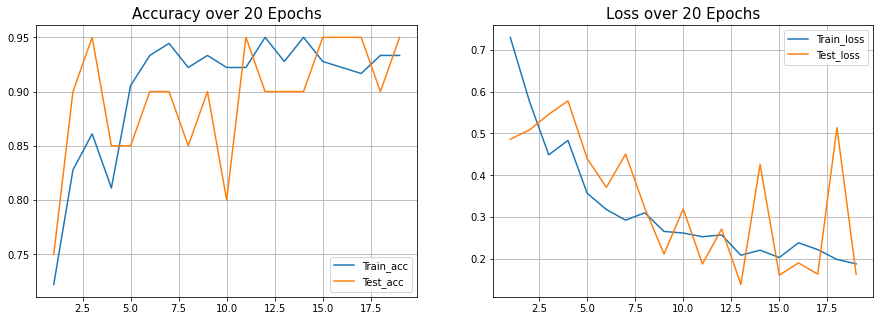

[0.20947134494781494, 0.8518518805503845]

 Fold 5 

Found 180 images belonging to 3 classes.
Found 20 images belonging to 3 classes.
Epoch 1/20
18/18 [==============================] - 4s 234ms/step - loss: 1.0643 - acc: 0.4611 - val_loss: 0.9956 - val_acc: 0.6500
Epoch 2/20
18/18 [==============================] - 4s 230ms/step - loss: 0.7478 - acc: 0.7056 - val_loss: 0.8378 - val_acc: 0.5000
Epoch 3/20
18/18 [==============================] - 4s 230ms/step - loss: 0.5568 - acc: 0.8389 - val_loss: 0.6453 - val_acc: 0.8000
Epoch 4/20
18/18 [==============================] - 4s 231ms/step - loss: 0.4415 - acc: 0.8833 - val_loss: 0.5629 - val_acc: 0.7000
Epoch 5/20
18/18 [==============================] - 4s 233ms/step - loss: 0.4146 - acc: 0.8833 - val_loss: 0.7057 - val_acc: 0.7000
Epoch 6/20
18/18 [==============================] - 4s 231ms/step - loss: 0.3192 - acc: 0.9111 - val_loss: 0.6985 - val_acc: 0.7500
Epoch 7/20
18/18 [==============================] - 4s 228ms/step - loss: 

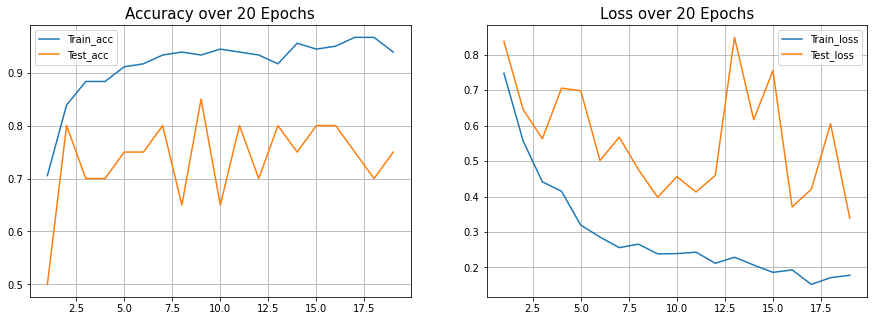

[0.4684276282787323, 0.7777777910232544]

 Fold 6 

Found 180 images belonging to 3 classes.
Found 20 images belonging to 3 classes.
Epoch 1/20
18/18 [==============================] - 4s 231ms/step - loss: 1.0252 - acc: 0.5167 - val_loss: 0.9583 - val_acc: 0.6500
Epoch 2/20
18/18 [==============================] - 4s 227ms/step - loss: 0.7051 - acc: 0.7944 - val_loss: 0.5690 - val_acc: 0.9500
Epoch 3/20
18/18 [==============================] - 4s 231ms/step - loss: 0.5310 - acc: 0.8500 - val_loss: 0.6069 - val_acc: 0.9500
Epoch 4/20
18/18 [==============================] - 4s 231ms/step - loss: 0.4543 - acc: 0.8556 - val_loss: 0.3911 - val_acc: 0.8500
Epoch 5/20
18/18 [==============================] - 4s 227ms/step - loss: 0.3906 - acc: 0.8944 - val_loss: 0.5498 - val_acc: 0.9000
Epoch 6/20
18/18 [==============================] - 4s 225ms/step - loss: 0.3404 - acc: 0.9333 - val_loss: 0.4055 - val_acc: 0.9000
Epoch 7/20
18/18 [==============================] - 4s 225ms/step - loss: 0

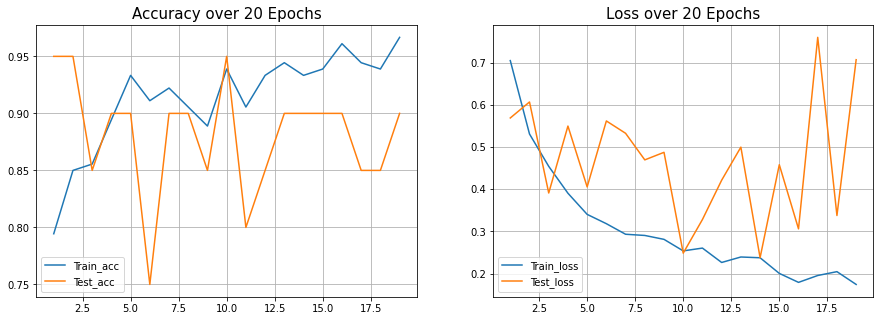

[0.32746100425720215, 0.8148148059844971]

 Fold 7 

Found 180 images belonging to 3 classes.
Found 20 images belonging to 3 classes.
Epoch 1/20
18/18 [==============================] - 4s 225ms/step - loss: 1.0502 - acc: 0.4111 - val_loss: 0.8103 - val_acc: 0.6000
Epoch 2/20
18/18 [==============================] - 4s 228ms/step - loss: 0.6984 - acc: 0.7500 - val_loss: 0.5474 - val_acc: 0.8500
Epoch 3/20
18/18 [==============================] - 4s 224ms/step - loss: 0.5508 - acc: 0.8611 - val_loss: 0.4978 - val_acc: 0.8500
Epoch 4/20
18/18 [==============================] - 4s 223ms/step - loss: 0.4496 - acc: 0.8667 - val_loss: 0.5830 - val_acc: 0.7000
Epoch 5/20
18/18 [==============================] - 4s 223ms/step - loss: 0.4183 - acc: 0.8722 - val_loss: 0.5600 - val_acc: 0.8500
Epoch 6/20
18/18 [==============================] - 4s 226ms/step - loss: 0.3709 - acc: 0.9000 - val_loss: 0.3055 - val_acc: 0.9000
Epoch 7/20
18/18 [==============================] - 4s 226ms/step - loss: 

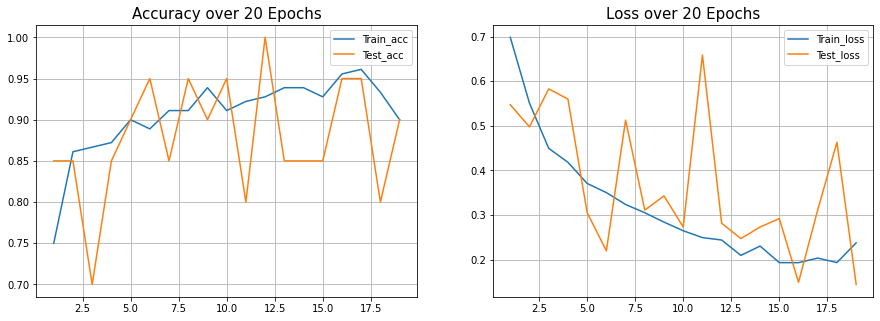

[0.6700974702835083, 0.7777777910232544]

 Fold 8 

Found 180 images belonging to 3 classes.
Found 20 images belonging to 3 classes.
Epoch 1/20
18/18 [==============================] - 4s 233ms/step - loss: 0.9858 - acc: 0.4944 - val_loss: 0.6302 - val_acc: 0.7500
Epoch 2/20
18/18 [==============================] - 4s 232ms/step - loss: 0.7079 - acc: 0.7611 - val_loss: 0.6328 - val_acc: 0.9000
Epoch 3/20
18/18 [==============================] - 4s 231ms/step - loss: 0.5748 - acc: 0.8111 - val_loss: 0.4523 - val_acc: 0.9000
Epoch 4/20
18/18 [==============================] - 4s 228ms/step - loss: 0.5411 - acc: 0.8111 - val_loss: 0.7039 - val_acc: 0.7500
Epoch 5/20
18/18 [==============================] - 4s 227ms/step - loss: 0.4209 - acc: 0.9000 - val_loss: 0.3859 - val_acc: 0.8500
Epoch 6/20
18/18 [==============================] - 4s 228ms/step - loss: 0.3460 - acc: 0.8889 - val_loss: 0.2453 - val_acc: 0.9500
Epoch 7/20
18/18 [==============================] - 4s 228ms/step - loss: 0

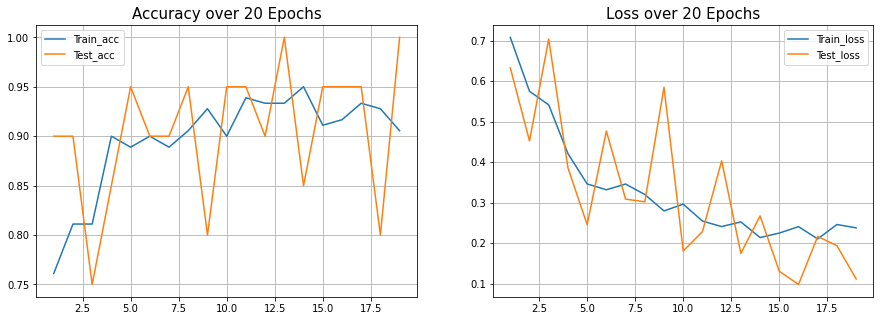

[0.3148277699947357, 0.7407407164573669]

 Fold 9 

Found 180 images belonging to 3 classes.
Found 20 images belonging to 3 classes.
Epoch 1/20
18/18 [==============================] - 4s 234ms/step - loss: 1.0657 - acc: 0.4278 - val_loss: 0.9209 - val_acc: 0.5500
Epoch 2/20
18/18 [==============================] - 4s 231ms/step - loss: 0.7230 - acc: 0.7667 - val_loss: 0.5331 - val_acc: 0.6500
Epoch 3/20
18/18 [==============================] - 4s 232ms/step - loss: 0.5545 - acc: 0.8444 - val_loss: 0.6843 - val_acc: 0.6500
Epoch 4/20
18/18 [==============================] - 4s 227ms/step - loss: 0.4464 - acc: 0.8778 - val_loss: 0.5779 - val_acc: 0.8000
Epoch 5/20
18/18 [==============================] - 4s 228ms/step - loss: 0.4153 - acc: 0.8611 - val_loss: 0.6692 - val_acc: 0.8500
Epoch 6/20
18/18 [==============================] - 4s 228ms/step - loss: 0.3370 - acc: 0.9278 - val_loss: 0.2432 - val_acc: 0.9000
Epoch 7/20
18/18 [==============================] - 4s 230ms/step - loss: 0

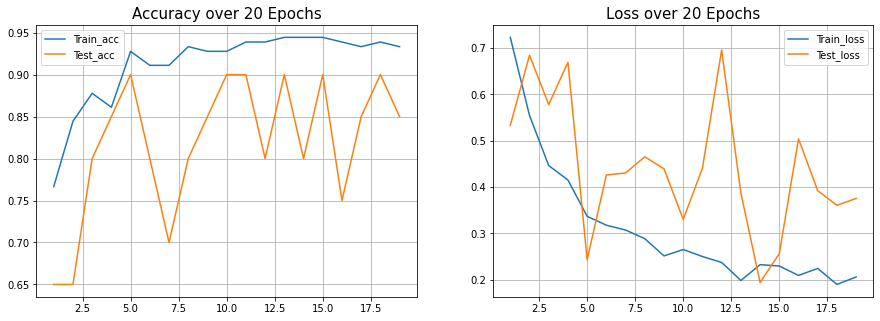

[0.5914534330368042, 0.7777777910232544]
CPU times: user 16min 5s, sys: 25.8 s, total: 16min 31s
Wall time: 14min 7s


In [ ]:
%%time
for k in range(FOLDS):
  model.set_weights(weights)
  train, test = kfold.gen_fold(k)

  print('\n', 'Fold', k, '\n')

  train_batches = train_datagen.flow_from_directory(train,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical')
  valid_batches = train_datagen.flow_from_directory(test,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical')

  STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
  STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size
  model.set_weights(weights)
  result = model.fit_generator(train_batches,
                            steps_per_epoch =STEP_SIZE_TRAIN,
                            validation_data = valid_batches,
                            validation_steps = STEP_SIZE_VALID,
                            epochs= NUM_EPOCHS)
  evaluation = model.evaluate_generator(test_batches)

  results.append(result)
  evaluations.append(evaluation)

  plot_acc_loss(result, 20)
  print(evaluation)

  kfold.del_fold(k)

In [ ]:
#STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
#STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size
#result=model.fit_generator(train_batches,
#                           steps_per_epoch =STEP_SIZE_TRAIN,
#                           validation_data = valid_batches,
#                           validation_steps = STEP_SIZE_VALID,
#                           epochs= NUM_EPOCHS)

In [ ]:
final_val_accs = np.array([1.0, 0.9, 1.0, 0.95, 0.95, 0.75, 0.9, 0.9, 1.0, 0.85]) #from the printed val accs, above
print('Val Acc Avg: ', final_val_accs.mean())
print('Test Acc Avg: ', np.array(evaluations)[:,1].mean())

Val Acc Avg:  0.9199999999999999
Test Acc Avg:  0.7925925970077514
